In [3]:
!pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/fa/80/eb88edc2e2b11cd2dd2e56f1c80b5784d11d6e6b7f04a1145df64df40065/opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB 1.3 MB/s eta 0:00:31
   ---------------------------------------- 0.1/39.0 MB 648.1 kB/s eta 0:01:01
   ---------------------------------------- 0.1/39.0 MB 655.4 kB/s eta 0:01:00
   ---------------------------------------- 0.1/39.0 MB 654.9 kB/s eta 0:01:00
   ---------------------------------------- 0.2/39.0 MB 888.4 kB/s eta 0:00:44
   ---------------------------------------- 0.3/39.0 MB 962.4 kB/s eta 0:00:41
   ---------------------------------------- 0.3/39.0 MB 1.0 MB/s eta 0:00:37
   ---------------------------------------- 0.3/39.0 MB 982.3 kB/s eta 0:00:40
   ---------------------------------------- 0.4/39.0 MB 1.0 MB/s eta 0:00:39
   


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

# This ensures plots are displayed inline in the notebook
%matplotlib inline

In [6]:
def gamma_correction(img, gamma):
    """
    Applies gamma correction: s = c * r^gamma
    """
    # Create a lookup table (LUT) for speed
    # We normalize 0-255 to 0-1, apply gamma, then scale back
    table = np.array([((i / 255.0) ** gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    
    # Apply LUT
    return cv2.LUT(img, table)

def contrast_stretching(img, r1, r2):
    """
    Applies piecewise linear contrast stretching.
    s(r) = 0                       if r < r1
    s(r) = (r - r1) / (r2 - r1)    if r1 <= r <= r2
    s(r) = 1                       if r > r2
    Input r is expected to be normalized [0, 1] for the logic, 
    but we handle the 0-255 uint8 conversion inside.
    """
    # Convert to float [0, 1] for easy calculation
    img_float = img.astype(np.float32) / 255.0
    output = np.zeros_like(img_float)
    
    # Vectorized masking (efficient implementation)
    
    # 1. Range: r1 <= r <= r2
    mask_middle = (img_float >= r1) & (img_float <= r2)
    output[mask_middle] = (img_float[mask_middle] - r1) / (r2 - r1)
    
    # 2. Range: r > r2
    mask_high = img_float > r2
    output[mask_high] = 1.0
    
    # 3. Range: r < r1 is already 0.0 (from np.zeros_like)

    # Scale back to [0, 255]
    return (output * 255).astype(np.uint8)

Images saved correctly.


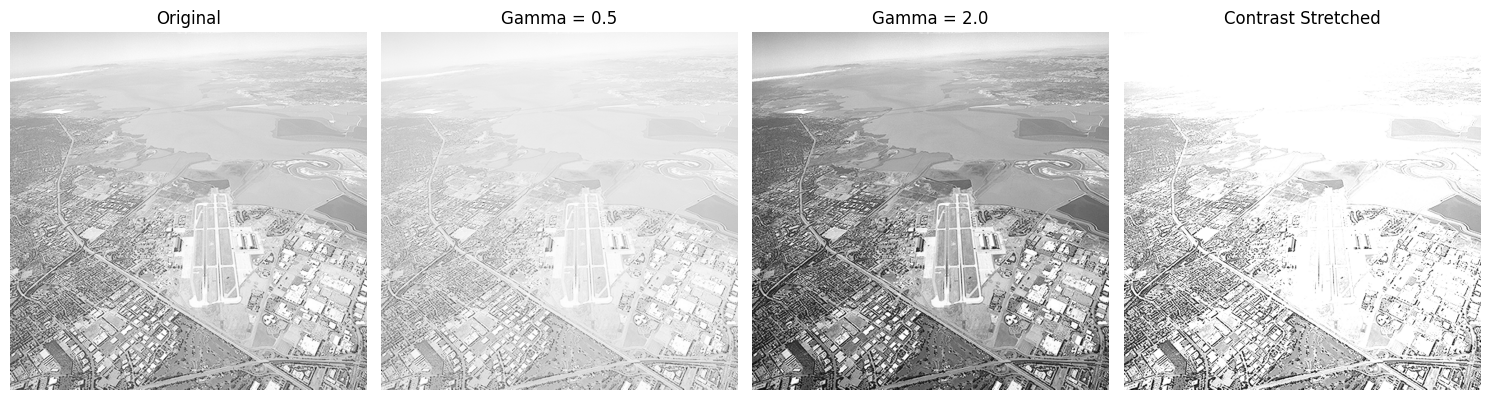

In [22]:
import os

# Load image in Grayscale
img_path = '../images/runway.png'
img = cv2.imread(img_path)

if img is None:
    print(f"Error: Could not load image from {img_path}. Check the file path.")
else:
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img

    # Apply transforms
    gamma_05 = gamma_correction(img_gray, gamma=0.5)
    gamma_20 = gamma_correction(img_gray, gamma=2.0)
    contrast_stretched = contrast_stretching(img_gray, r1=0.2, r2=0.8)

    # --- Saving (Use OpenCV/BGR) ---
    output_dir = '../images/outputs'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    cv2.imwrite(os.path.join(output_dir, 'q1_runway_gamma_05.jpg'), gamma_05)
    cv2.imwrite(os.path.join(output_dir, 'q1_runway_gamma_20.jpg'), gamma_20)
    cv2.imwrite(os.path.join(output_dir, 'q1_runway_contrast_stretched.jpg'), contrast_stretched)
    print("Images saved correctly.")

    # --- Plotting (Convert to RGB for Matplotlib) ---
    # Since these are grayscale, we just need to tell matplotlib it's 'gray'
    # If they were color, we would use: img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15, 10))

    images = [img_gray, gamma_05, gamma_20, contrast_stretched]
    titles = ['Original', 'Gamma = 0.5', 'Gamma = 2.0', 'Contrast Stretched']

    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()